# Loading Models and libraries

In [3]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/noorsaeed/resume-datasets
?select=clean_resume_data.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  mostafahamed779@gmail.com


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/noorsaeed/resume-datasets


100%|████████████████████████████████████████████████████████████████████████████████| 142M/142M [00:00<00:00, 993MB/s]

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # train/test
from sklearn.feature_extraction.text import TfidfVectorizer # Dealing w Text , Turning Text into Numbers for model
from sklearn.ensemble import RandomForestClassifier # classification model  , مش بيتاثر ب النويز بسهوله واحسن لو فيه فيتشرز كتيره
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report # accuracy
from sklearn.utils import resample
import pickle # Saving model into files
import re
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# from google.colab import files


# Import and Clean Dataset

In [6]:
clean_df= pd.read_csv('/resume-datasets/clean_resume_data.csv')
clean_df.head()


,ID,Category,Feature
0,16852973,HR,hr administrator marketing associate hr admini...
1,22323967,HR,hr specialist hr operations summary media prof...
2,33176873,HR,hr director summary years experience recruitin...
3,27018550,HR,hr specialist summary dedicated driven dynamic...
4,17812897,HR,hr manager skill highlights hr skills hr depar...


In [7]:
clean_df.shape

(2484, 3)

**Cleaning Data**

In [8]:
clean_df.isnull().sum() # We have nulls after this step


ID          0
Category    0
Feature     1
dtype: int64

In [9]:
clean_df.dropna(inplace=True) # inplace True he will change in the original DF


In [10]:
clean_df.isnull().sum()


ID          0
Category    0
Feature     0
dtype: int64

In [11]:
# Clean resume
def cleanResume(txt):
    cleanText = re.sub(r'http\S+\s', ' ', txt)
    cleanText = re.sub(r'RT|cc', ' ', cleanText)
    cleanText = re.sub(r'#\S+\s', ' ', cleanText)
    cleanText = re.sub(r'@\S+', ' ', cleanText)
    cleanText = re.sub(r'[%s]' % re.escape(r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleanText)
    cleanText = re.sub(r'[^\x00-\x7f]', ' ', cleanText)
    cleanText = re.sub(r'\s+', ' ', cleanText)
    return cleanText

In [12]:
clean_df['Feature'] = clean_df['Feature'].apply(cleanResume) # Applying Cleaning Function

In [13]:
clean_df['Category'].value_counts()


Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      119
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

In [14]:
clean_df['Category'].unique()


array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

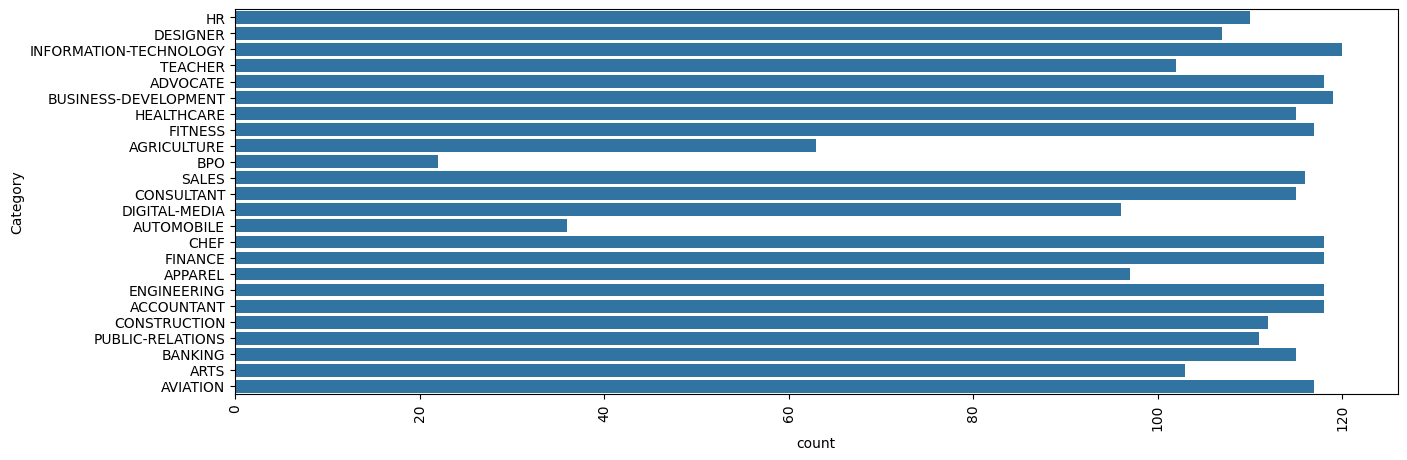

In [15]:
plt.figure(figsize=(15,5))
sns.countplot(clean_df['Category'])
plt.xticks(rotation=90)
plt.show()

**here we see the data is unbalanced**

# Balance Dataset


In [16]:

# Define the maximum count among all categories
cat_counts = clean_df['Category'].value_counts()
target_count = min(100, cat_counts.max())  #if categ.max < 100 make them 100 | else let them


# Resample each category to match the maximum count
balanced_data = []
for category in clean_df['Category'].unique():
    category_data = clean_df[clean_df['Category'] == category]
    if len(category_data) < target_count:

         # Oversampling → category < target_count → duplicate samples
         # Replace True = Each row maybe will take more than one time
        balanced_category_data = resample(category_data, replace=True, n_samples=target_count, random_state=42)
    else:

        # Undersampling → category > target_count → remove samples
        # Replace False = Each row will taking one time
        balanced_category_data = resample(category_data, replace=False, n_samples=target_count, random_state=42)
    balanced_data.append(balanced_category_data)

# Concatenate the balanced data for all categories
balanced_df = pd.concat(balanced_data)

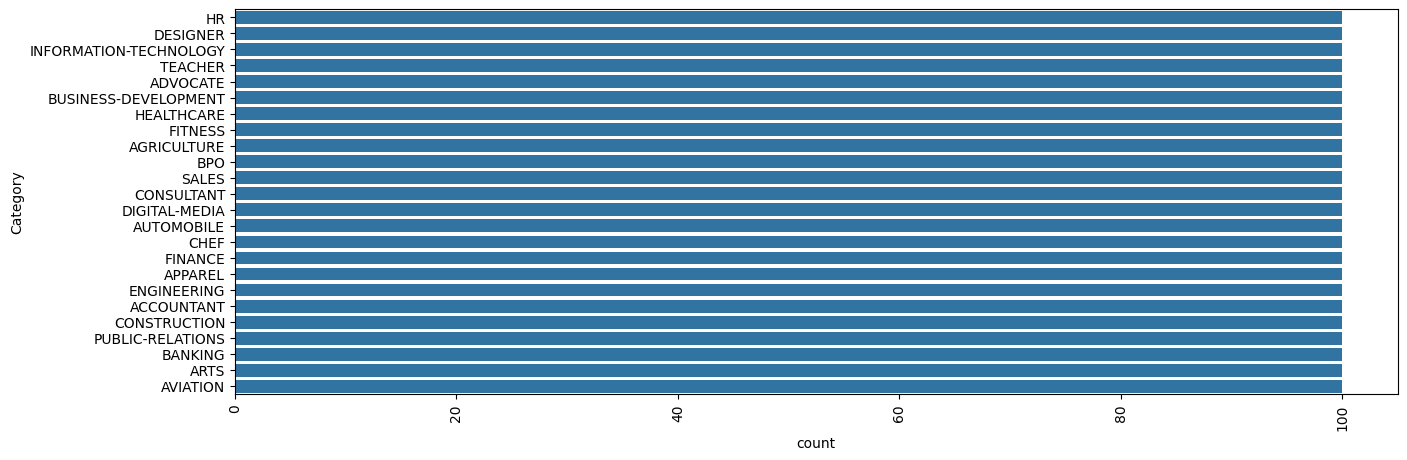

In [17]:
plt.figure(figsize=(15,5))
sns.countplot(balanced_df['Category'])
plt.xticks(rotation=90)
plt.show()
# All classes is equal to each others

# Train-Test Split


In [18]:
X = balanced_df['Feature'] # Input for model to train
y = balanced_df['Category'] # Output
#Split data into 80% Train , 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encoding (TF-IDF)


In [19]:
#TF-IDF -> The model can’t understand text directly it only understands numbers.
# TF-IDF (Term Frequency – Inverse Document Frequency) converts words into numeric weights that show how important each word is within a document compared to all others.




# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Learn vocabulary from training data and transform it into TF-IDF matrix
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform test data using the same vocabulary (no re-fitting)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train Model



Accuracy: 0.7916666666666666
                        precision    recall  f1-score   support

            ACCOUNTANT       0.81      1.00      0.89        21
              ADVOCATE       0.80      0.93      0.86        30
           AGRICULTURE       0.94      0.81      0.87        21
               APPAREL       1.00      0.86      0.92        14
                  ARTS       0.82      0.45      0.58        20
            AUTOMOBILE       0.96      1.00      0.98        25
              AVIATION       0.86      0.80      0.83        15
               BANKING       0.89      0.67      0.76        24
                   BPO       0.96      1.00      0.98        24
  BUSINESS-DEVELOPMENT       0.60      0.56      0.58        16
                  CHEF       0.92      0.80      0.86        15
          CONSTRUCTION       0.71      0.94      0.81        16
            CONSULTANT       0.53      0.44      0.48        18
              DESIGNER       0.87      0.95      0.91        21
         D

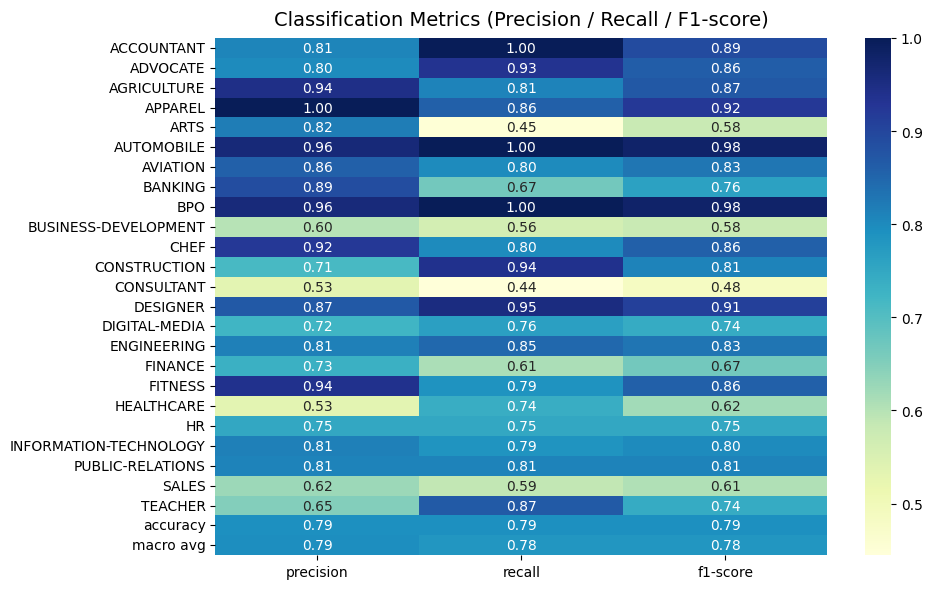

In [20]:
# Precision -> قد إيه من التوقعات الصحيحة كانت فعلاً صحيحة
# Recall -> قد إيه من الحالات الصحيحة الموديل قدر يكتشفها
# F1-score ->   متوسط ال Recall , precision وبيديك رقم واحد يعبر عن الاتنين دول

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 2) Model
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist"
)

# 3) train
xgb_model.fit(X_train_tfidf, y_train_enc)

# 4) prediction
y_pred_enc = xgb_model.predict(X_test_tfidf)

# 5) رجّع الأرقام لأسماء عشان ال report
y_pred = le.inverse_transform(y_pred_enc)
y_test_labels = le.inverse_transform(y_test_enc)

# 6) accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test_labels, y_pred))

# ====== classification report heatmap ======
report_dict = classification_report(y_test_labels, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(
    report_df.iloc[:-1, :-1],
    annot=True,
    fmt=".2f",
    cmap="YlGnBu"
)
plt.title("Classification Metrics (Precision / Recall / F1-score)", fontsize=14, pad=10)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Predictive System


In [21]:
# Prediction and Category Name using XGBoost
def predict_category(resume_text):

    # 1) clean text
    resume_text = cleanResume(resume_text)

    # 2) vectorize
    resume_tfidf = tfidf_vectorizer.transform([resume_text])

    # 3) predict
    pred_enc = xgb_model.predict(resume_tfidf)[0]

    pred_label = le.inverse_transform([pred_enc])[0]

    return pred_label

**Examples To Predict**

In [22]:
# Example Usage
resume_file = """Objective:
Dedicated and results-oriented Banking professional with a strong background in financial analysis and customer service seeking opportunities to contribute to a reputable financial institution. Eager to leverage expertise in risk management, investment strategies, and relationship building to drive business growth and client satisfaction.

Education:
- Bachelor of Business Administration in Finance, XYZ University, GPA: 3.8/4.0
- Certified Financial Analyst (CFA) Level I Candidate

Skills:
- Proficient in financial modeling and analysis using Excel, Bloomberg Terminal, and other financial software
- Extensive knowledge of banking products and services, including loans, mortgages, and investment products
- Strong understanding of regulatory compliance and risk management practices in the banking industry
- Excellent communication and interpersonal skills, with a focus on building rapport with clients and colleagues
- Ability to work efficiently under pressure and adapt to changing market conditions

Experience:
Financial Analyst | ABC Bank
- Conducted financial analysis and risk assessment for corporate clients, including credit analysis, financial statement analysis, and cash flow modeling
- Developed customized financial solutions to meet clients' needs and objectives, resulting in increased revenue and client retention
- Collaborated with cross-functional teams to identify new business opportunities and optimize existing processes

Customer Service Representative | DEF Bank
- Provided exceptional customer service to bank clients, addressing inquiries, resolving issues, and promoting banking products and services
- Processed transactions accurately and efficiently, including deposits, withdrawals, and account transfers
- Educated customers on various banking products and services, helping them make informed financial decisions

Internship | GHI Investments
- Assisted portfolio managers with investment research and analysis, including industry and company-specific research, financial modeling, and performance analysis
- Prepared investment presentations and reports for clients, highlighting investment opportunities and performance metrics
- Conducted market research and analysis to identify trends and opportunities in the financial markets

Certifications:
- Certified Financial Planner (CFP)
- Series 7 and Series 63 Securities Licenses

Languages:
- English (Native)
- Spanish (Proficient)

"""
predicted_category = predict_category(resume_file)
print("Predicted Category:", predicted_category)

Predicted Category: BANKING


In [23]:
# Example Usage
resume_file = """Objective:
A creative and detail-oriented Designer with a passion for visual communication and brand identity seeking opportunities to leverage design skills in a dynamic and collaborative environment.

Education:
- Bachelor of Fine Arts in Graphic Design, XYZ College, GPA: 3.7/4.0
- Diploma in Web Design, ABC Institute, GPA: 3.9/4.0

Skills:
- Proficient in Adobe Creative Suite (Photoshop, Illustrator, InDesign)
- Strong understanding of typography, layout, and color theory
- Experience in both print and digital design
- Ability to conceptualize and execute design projects from concept to completion
- Excellent attention to detail and time management skills

Experience:
Graphic Designer | XYZ Design Studio
- Created visually appealing graphics for various marketing materials, including brochures, flyers, and social media posts
- Collaborated with clients to understand their design needs and deliver creative solutions that align with their brand identity
- Worked closely with the marketing team to ensure consistency in brand messaging across all platforms

Freelance Designer
- Designed logos, branding materials, and website layouts for small businesses and startups
- Managed multiple projects simultaneously while meeting tight deadlines and maintaining quality standards
- Established and maintained strong client relationships through clear communication and exceptional service

Projects:
- Rebranding Campaign for XYZ Company: Led a team to redesign the company's logo, website, and marketing collateral, resulting in a 30% increase in brand recognition
- Packaging Design for ABC Product Launch: Developed eye-catching packaging designs for a new product line, contributing to a successful launch and positive customer feedback

Certifications:
- Adobe Certified Expert (ACE) in Adobe Illustrator
- Responsive Web Design Certification from Udemy

Languages:
- English (Native)
- Spanish (Intermediate)
"""
predicted_category = predict_category(resume_file)
print("Predicted Category:", predicted_category)

Predicted Category: DESIGNER


**Save model and vectorizer**

In [24]:
import joblib  # if not already imported

# Save the trained label encoder so Django can decode predictions
joblib.dump(le, "label_encoder.joblib")

print("✅ Label encoder saved as label_encoder.joblib")


✅ Label encoder saved as label_encoder.joblib
